# Google Earth Engine Batch Downloading Script

Script edited from https://github.com/KuntaHu/GEE_batch_download

Useful resources:
- https://code.earthengine.google.com
- https://github.com/google/earthengine-api
- https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/authorize_notebook_server.ipynb

In [ ]:
!pip install google-api-python-client
!pip install oauth2client
!pip install earthengine-api

In [ ]:
!earthengine upload image -h

In [1]:
import ee

In [2]:
try:
  ee.Initialize()
  print('The Earth Engine package initialized successfully!')
except ee.EEException as e:
  print('The Earth Engine package failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

The Earth Engine package initialized successfully!


In [ ]:
### ONLY if authentication failed ###
!earthengine authenticate --quiet

In [ ]:
### ONLY if authentication failed ###
!earthengine authenticate --authorization-code=PLACE_AUTH_CODE_HERE

ee.Image({
  "type": "Invocation",
  "arguments": {
    "id": "LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913"
  },
  "functionName": "Image.load"
})
{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [7961, 7301], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 270285, 0, -30, 4414815]}, {'id': 'B5', 'data_type': {'t

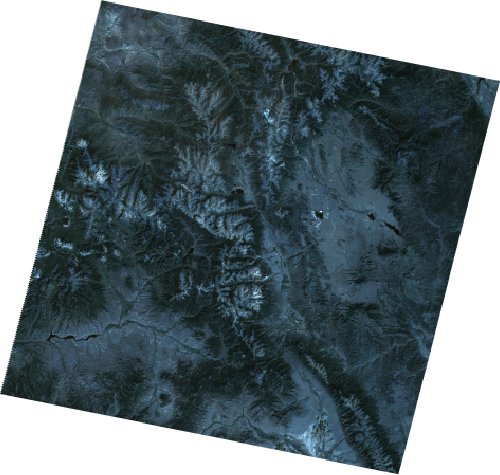

In [3]:
from IPython.display import Image

# Load a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

print(img)
print(img.getInfo())

url = img.getThumbURL({
        'min': 0,
        'max': 3000,
        'dimensions': 500,})

print(url)
Image(url, format='png')

In [4]:
import os
import logging
import sys
import zipfile

import urllib.request as request
import numpy as np

In [5]:
def url_download(url, savePath, saveName):

    logging.basicConfig(
        format='%(asctime)s %(levelname)s %(message)s',
        level=logging.INFO,
        stream=sys.stdout)
    
    filePath = savePath + saveName

    if os.path.isfile(filePath):
        os.system("rm " + filePath)
        logging.info("Existed file deleted: " + saveName)
    else:
        logging.info("File doesn't exist.")

    file_dir = savePath
    if not os.path.exists(file_dir):
        logging.info("Make direction: " + savePath)
        os.mkdir(file_dir)

    def down(_save_path, _url):
        try:
            request.urlretrieve(_url, _save_path)
            return True
        except:
            print('\nError when retrieving the URL:\n{}'.format(_url))
            return False

    flag = down(filePath, url)
    if flag:
        print("------- Download Finished! ---------")
    else:
        print("------- Download Fail --------")

In [6]:
def un_zip(dataPath, dataName, unzipPath):
    """unzip zip file"""
    
    zip_file = zipfile.ZipFile(dataPath + dataName + ".zip")
    
    if os.path.isdir(unzipPath):
        pass
    else:
        os.mkdir(unzipPath)
    
    for names in zip_file.namelist():
        zip_file.extract(names, unzipPath)
    
    zip_file.close()

In [7]:
def batchReName(dataPath, savePath, saveName):
    
    print("dataPath: " + dataPath)
    
    for file in os.listdir(dataPath):
        format = "." + file.split(".")[-1]
        orginalName = file.split(".")[0]
        saveFileName = file.replace(orginalName, saveName)

        if format == ".tif" and ('angle' not in file):
            if os.path.isfile(savePath + saveFileName):
                os.system("rm " + savePath + saveFileName)
            os.rename(dataPath + file, savePath + saveFileName)

In [8]:
def batch_data_download_GEE(downLoadList, pathKeyWord, scale, bands4download, toRGBflag):

    savePath = rootPath + "{:}_{:}m_{:}_GEE_download_zip/".format(fireName, scale, pathKeyWord)
    tifPath = rootPath + "{:}_{:}m_{:}_Tif_collection/".format(fireName, scale, pathKeyWord)
    pngPath = rootPath + "{:}_{:}m_{:}_PNG_collection/".format(fireName, scale, pathKeyWord)
    rgbPath = rootPath + "{:}_{:}m_{:}_RGB_collection/".format(fireName, scale, pathKeyWord)
    
    print("downloadList: {}".format(downLoadList))

    for saveName in downLoadList:

        img = globals()[saveName]
        img = ee.Image(img)

        if len(bands4download) > 0:
            url = (img.select(bands4download).getDownloadUrl(
                {
                    'region': fireCoords,
                    'scale': scale,
                }
            ))
        else:
            url = (img.getDownloadUrl(
                {
                    'region': fireCoords,
                    'scale': scale,
                }
            ))

        if not os.path.exists(savePath):
            os.makedirs(savePath)

        print("{}:\n {}".format(saveName, url))
        print("savePath:", savePath)
        url_download(url=url, savePath=savePath, saveName=saveName + ".zip")

        unzipPath = savePath + "unzipedFiles/"
        un_zip(savePath, saveName, unzipPath)

        renamePath = savePath + "renamedFiles/"
        renamedName = saveName

        os.system("rd/s/q " + renamePath)

        if not os.path.exists(renamePath):
            os.makedirs(renamePath)
        batchReName(unzipPath, renamePath, renamedName)

        # ======================================================

        os.system("rd/s/q " + tifPath)  # remove directory
#         shutil.copytree(renamePath, tifPath)  # move directory

#         from snappy_tif_processing import tif2png, tif2snapTif
        from gdal_tif2rgb import tifBand2png_GDAL, bandsMerge2tif

        bandsMerge2tif(renamePath, saveName, tifPath, saveName, stretchFlag=True)

        for file in os.listdir(renamePath):
            fileName = file[:-4]
            tifBand2png_GDAL(renamePath, fileName, pngPath, fileName)
#             shutil.copy(renamePath + fileName + ".tif", tifPath)
#             tif2snapTif(renamePath, fileName, tifPath) # copy tif files

        # ## ============== delete directory =====================
        os.system("rd/s/q " + unzipPath)
        os.system("rd/s/q " + renamePath)
        os.system("rm " + savePath + saveName + ".zip")

        if toRGBflag:
            from bands2rgb import pngBand2rgb
            if satName == 'S2':
                rgbBands = ['B4','B5','B6','B7']
            elif satName == 'L8':
                rgbBands = ['B7', 'B6', 'B7']
            pngBand2rgb(pngPath, saveName, rgbPath, saveName, bands=rgbBands)

In [9]:
def set_timeEnd_newdays(img):
    group_days = img.date().format().slice(0, 10)
    return img.set('system:time_end', group_days)

# "group by" date
def group_days(imgcollection):
    imgCol_sort = imgcollection.sort("system:time_start")
    imgCol = imgCol_sort.map(set_timeEnd_newdays)
    d = imgCol.distinct(['system:time_end'])
    di = ee.ImageCollection(d)
    date_eq_filter = (ee.Filter.equals(leftField= 'system:time_end',
                                       rightField ='system:time_end'))
    saveall = ee.Join.saveAll("to_mosaic")
    j = saveall.apply(di, imgCol, date_eq_filter)
    ji = ee.ImageCollection(j)
    original_proj = ee.Image(ji.first()).select(0).projection()

    def mosaicImageBydate(img):
        mosaiced = ee.ImageCollection.fromImages(img.get('to_mosaic')).mosaic().copyProperties(img, img.propertyNames())
        return ee.Image(mosaiced)

    imgcollection_grouped = ji.map(mosaicImageBydate)

    return ee.ImageCollection(imgcollection_grouped.copyProperties(imgCol, imgCol.propertyNames()))

In [10]:
if __name__ == "__main__":
    
    ee.Initialize()    

    # https://www.bbc.com/news/world-australia-50951043

    # Stirling Ranges
    stirlingRanges = ee.Geometry.Rectangle([118.39626387050868,-34.58409156988779611,
                                   7.93895796230555,-34.23796977775188])
    stirlingRangesCoords = [[118.39626387050868,-34.584091569887796],[118.39626387050868,-34.23796977775188],
                   [117.93895796230555,-34.23796977775188],[117.93895796230555,-34.584091569887796]]
    
    # Green Range
    greenRange = ee.Geometry.Rectangle([118.53999746565552,-34.80035628523257,
                                   118.53999746565552,-34.63498692719189])
    greenRangeCoords = [[118.53999746565552,-34.80035628523257],[118.53999746565552,-34.63498692719189],
                        [118.34293020491333,-34.63498692719189],[118.34293020491333,-34.80035628523257]]
    
    # Kangaroo Island
    kangaroo1 = ee.Geometry.Rectangle([137.0236760454415,-36.01656363886284,
                                  137.0236760454415,-35.687087090873725])
    kangarooCoords1 = [[137.0236760454415,-36.01656363886284],[137.0236760454415,-35.687087090873725],
                       [136.61992848684775,-35.687087090873725],[136.61992848684775,-36.01656363886284]]
    kangaroo2 = ee.Geometry.Rectangle([137.0099431352853,-35.9524845307082,
                                  137.4219304399728,-35.62943892813193])
    kangarooCoords2 = [[137.0099431352853,-35.9524845307082],[137.4219304399728,-35.9524845307082],
                       [137.4219304399728,-35.62943892813193],[137.0099431352853,-35.62943892813193]]
    kangaroo3 = ee.Geometry.Rectangle([136.78746999075406,-35.94581414032577,
                                 137.19945729544156,-35.622741369164636])
    kangarooCoords3 = [[136.78746999075406,-35.94581414032577],[137.19945729544156,-35.94581414032577],
                       [137.19945729544156,-35.622741369164636],[136.78746999075406,-35.622741369164636]]
    
    # Bundaberg
    bundaberg = ee.Geometry.Rectangle([152.0143622184071,-25.102201044735597,
                                       152.3123663687977,-24.856346559536906])
    bundabergCoords = [[152.0143622184071,-25.102201044735597],[152.3123663687977,-25.102201044735597],
                       [152.3123663687977,-24.856346559536906],[152.0143622184071,-24.856346559536906]]
    
    # Turkey Beach
    turkeyBeach = ee.Geometry.Rectangle([151.51723087075084,-24.198559095007315,
                                        151.81523502114146,-23.950927141228142])
    turkeyBeachCoords = [[151.51723087075084,-24.198559095007315],[151.81523502114146,-24.198559095007315],
                         [151.81523502114146,-23.950927141228142],[151.51723087075084,-23.950927141228142]]
    
    # Marlborough
    marlborough = ee.Geometry.Rectangle([150.08900821450084,-23.1067011917665,
                                        149.7910040641102,-22.857004000568214])
    marlboroughCoords = [[150.08900821450084,-23.1067011917665],[150.08900821450084,-22.857004000568214],
                         [149.7910040641102,-22.857004000568214],[149.7910040641102,-23.1067011917665]]
    
    # Yeppoon
    yeppoon = ee.Geometry.Rectangle([150.4941290641102,-23.2405250180573,
                                        150.79213321450084,-22.99107607849743])
    yeppoonCoords = [[150.4941290641102,-23.2405250180573],[150.79213321450084,-23.2405250180573],
                     [150.79213321450084,-22.99107607849743],[150.4941290641102,-22.99107607849743]]
    
    # Norseman
    norseman = ee.Geometry.Rectangle([121.78941201361316,-32.46085754640999,
                                        121.11684273871082,-31.949288034818707])
    norsemanCoords = [[121.78941201361316,-32.46085754640999],[121.78941201361316,-31.949288034818707],
                      [121.11684273871082,-31.949288034818707],[121.11684273871082,-32.46085754640999]]
    
    # Lake Dundas
    lakeDundas = ee.Geometry.Rectangle([122.46919106634753,-32.88510371885524,
                                        121.79662179144519,-32.37594091616304])
    lakeDundasCoords = [[122.46919106634753,-32.88510371885524],[122.46919106634753,-32.37594091616304],
                        [121.79662179144519,-32.37594091616304],[121.79662179144519,-32.88510371885524]]
    
    # Balladonia
    balladonia = ee.Geometry.Rectangle([122.93096017035144,-32.68190193194026,
                                        123.50190591009753,-32.22271551906327])
    balladoniaCoords = [[122.93096017035144,-32.68190193194026],[123.50190591009753,-32.68190193194026],
                        [123.50190591009753,-32.22271551906327],[122.93096017035144,-32.22271551906327]]
    
    # Israelite Bay
    israeliteBay = ee.Geometry.Rectangle([123.81501626166003,-33.30618080220789,
                                        123.24407052191394,-32.85021145501178])
    israeliteBayCoords = [[123.81501626166003,-33.30618080220789],[123.81501626166003,-32.85021145501178],
                          [123.24407052191394,-32.85021145501178],[123.24407052191394,-33.30618080220789]]
    israeliteBay2 = ee.Geometry.Rectangle([123.92213296087878,-33.75035870202216,
                                        123.35118722113269,-33.29671155362697])
    israeliteBayCoords2 = [[123.92213296087878,-33.75035870202216],[123.92213296087878,-33.29671155362697],
                            [123.35118722113269,-33.29671155362697],[123.35118722113269,-33.75035870202216]]
    
    # Collie
    collie = ee.Geometry.Rectangle([116.47889565619128,-33.379604279934775,
                                        116.03429268988269,-33.00927775309742])
    collieCoords = [[116.47889565619128,-33.379604279934775],[116.47889565619128,-33.00927775309742],
                    [116.03429268988269,-33.00927775309742],[116.03429268988269,-33.379604279934775]]
    
    # -----------------------------------
    fire = collie
    fireCoords = collieCoords
    
    t1 = '2019-11-24'
    t2 = '2020-01-01'

    S2 = (ee.ImageCollection("COPERNICUS/S2")
          .filterDate(t1, t2)
          .filterBounds(fire)
          .sort('system:time_start'))

    # -----------------------------------
    satName = 'S2'
    col = globals()[satName]#.merge(L8)
    printImgIdBeforeMosaicFlag = True

    fireName = 'collie'
    preFix = 'MSI'
    scale = 50
    dNBR_Flag = False
    rootPath = "/home/robin/Documents/stanford/cs231n-project/download/"
    
    # ===================================
    
    if printImgIdBeforeMosaicFlag:
        print("-------------------------------------------------------")
        num0 = col.size().getInfo()
        print("Size of ImageCollection before Mosaicing: {}".format(num0))
        print("------------------- Image id List  --------------------")
        col_list = col.toList(num0)
        for idx in range(num0):
            img = ee.Image(col_list.get(idx))
            if 'S2' in satName:
                date = img.get("system:index").getInfo()[:8]
            elif 'L8' in satName:
                date = img.get("system:index").getInfo()[12:]
            else:
                date = None
                print("------------- No Matched Satellite ------------")

            varName = "{}_{}_{}".format(preFix, date, satName)
            
    print("--------------end--------------")

    # ===================================

    col_groupedBydate = group_days(col)
    num = col_groupedBydate.size().getInfo()
    
    print("-------------------------------------------------------")
    print("Size of ImageCollection after Mosaicing: {}".format(num))
    print("-------------------- Download List --------------------")
    dataList = col_groupedBydate.toList(num)

    msiDownLoadList = []
    
    for i in range(0, num):
        img = ee.Image(dataList.get(i))

        if 'S2' in satName:
            date = img.get("system:index").getInfo()[:8]
        elif 'L8' in satName:
            date = img.get("system:index").getInfo()[12:]
        else:
            date = None
            print("------------- No Matched Satellite ------------")

        varName = "{}_{}_{}".format(preFix, date, satName)
            
        globals()[varName] = img
        msiDownLoadList.append(varName)
        print("{}".format(varName))

    num = len(msiDownLoadList)
    print("Number of optical images: {}".format(num))
    print("----------------------------------------------------------")

    if satName == 'S2':
        swirBands = ['B4','B5','B6','B7']
    elif satName == 'L8':
        swirBands = ['B6', 'B7']
    else:
        swirBands = []

    batch_data_download_GEE(downLoadList=msiDownLoadList, pathKeyWord="MSI", scale=scale,
                            bands4download=swirBands, toRGBflag=True)


-------------------------------------------------------
Size of ImageCollection before Mosaicing: 15
------------------- Image id List  --------------------
--------------end--------------
-------------------------------------------------------
Size of ImageCollection after Mosaicing: 15
-------------------- Download List --------------------
MSI_20191125_S2
MSI_20191128_S2
MSI_20191130_S2
MSI_20191203_S2
MSI_20191205_S2
MSI_20191208_S2
MSI_20191210_S2
MSI_20191213_S2
MSI_20191215_S2
MSI_20191218_S2
MSI_20191220_S2
MSI_20191223_S2
MSI_20191225_S2
MSI_20191228_S2
MSI_20191230_S2
Number of optical images: 15
----------------------------------------------------------
downloadList: ['MSI_20191125_S2', 'MSI_20191128_S2', 'MSI_20191130_S2', 'MSI_20191203_S2', 'MSI_20191205_S2', 'MSI_20191208_S2', 'MSI_20191210_S2', 'MSI_20191213_S2', 'MSI_20191215_S2', 'MSI_20191218_S2', 'MSI_20191220_S2', 'MSI_20191223_S2', 'MSI_20191225_S2', 'MSI_20191228_S2', 'MSI_20191230_S2']
MSI_20191125_S2:
 https://e

MSI_20191205_S2.B6
MSI_20191125_S2.B7
MSI_20191130_S2.B4
MSI_20191208_S2.B7
MSI_20191213_S2.B5
MSI_20191125_S2.B4
MSI_20191130_S2.B5
MSI_20191205_S2.B7
MSI_20191203_S2.B7
MSI_20191205_S2.B5
MSI_20191213_S2.B4
MSI_20191210_S2.B6
MSI_20191210_S2.B4
MSI_20191130_S2.B6
MSI_20191208_S2.B6
MSI_20191210_S2.B5
MSI_20191128_S2.B7
MSI_20191208_S2.B4
MSI_20191125_S2.B5
MSI_20191128_S2.B6
MSI_20191128_S2.B4
MSI_20191208_S2.B5
MSI_20191128_S2.B5
MSI_20191130_S2.B7
MSI_20191210_S2.B7
MSI_20191213_S2.B6
MSI_20191205_S2.B4
MSI_20191203_S2.B5
MSI_20191203_S2.B4
MSI_20191125_S2.B6
MSI_20191213_S2.B7
2020-05-15 20:10:08,639 INFO URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails?fields=name&alt=json
MSI_20191215_S2:
 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c2f78352aa5cd09bb6dd54fd197e475d-f0dfa4d79e132f1b055f14c907cfc372:getPixels
savePath: /home/robin/Documents/stanford/cs231n-project/download/collie_50m_M

MSI_20191228_S2:
 https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87c35906b67f32351cf3cc1baa0fa914-a46542545490ac44ed1b4c2b08d1b6cd:getPixels
savePath: /home/robin/Documents/stanford/cs231n-project/download/collie_50m_MSI_GEE_download_zip/
2020-05-15 20:11:35,762 INFO File doesn't exist.
------- Download Finished! ---------
dataPath: /home/robin/Documents/stanford/cs231n-project/download/collie_50m_MSI_GEE_download_zip/unzipedFiles/
['B7', 'B4', 'B6', 'B5']
MSI_20191203_S2.B6
MSI_20191205_S2.B6
MSI_20191125_S2.B7
MSI_20191225_S2.B4
MSI_20191130_S2.B4
MSI_20191215_S2.B7
MSI_20191208_S2.B7
MSI_20191213_S2.B5
MSI_20191215_S2.B4
MSI_20191218_S2.B5
MSI_20191228_S2.B7
MSI_20191215_S2.B5
MSI_20191125_S2.B4
MSI_20191130_S2.B5
MSI_20191205_S2.B7
MSI_20191223_S2.B5
MSI_20191218_S2.B7
MSI_20191203_S2.B7
MSI_20191223_S2.B7
MSI_20191220_S2.B6
MSI_20191223_S2.B6
MSI_20191228_S2.B4
MSI_20191205_S2.B5
MSI_20191218_S2.B6
MSI_20191220_S2.B7
MSI_20191223_S2.B4
MSI_201912